Let's start by importing the modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import euclidean

Load the data and perform some analysis

In [2]:
file_path = 'archive/beer_profile_and_ratings.csv'
df = pd.read_csv(file_path)
print(df.head())  

                           Name    Style  \
0                         Amber  Altbier   
1                    Double Bag  Altbier   
2                Long Trail Ale  Altbier   
3                  Doppelsticke  Altbier   
4  Sleigh'r Dark Doüble Alt Ale  Altbier   

                                            Brewery  \
0                               Alaskan Brewing Co.   
1                            Long Trail Brewing Co.   
2                            Long Trail Brewing Co.   
3  Uerige Obergärige Hausbrauerei GmbH / Zum Uerige   
4                           Ninkasi Brewing Company   

                                    Beer Name (Full)  \
0                  Alaskan Brewing Co. Alaskan Amber   
1                  Long Trail Brewing Co. Double Bag   
2              Long Trail Brewing Co. Long Trail Ale   
3  Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...   
4  Ninkasi Brewing Company Sleigh'r Dark Doüble A...   

                                         Description  ABV  Min IBU 

The Name column can be dropped, as it's information is contained in the full beer name. We move this latter column to be the first and cut the data set to simplify the result, for now, after shuffling the data.

In [3]:
#reorder
new_columns = ['Beer Name (Full)'] + [col for col in df.columns if col != 'Beer Name (Full)']
df = df[new_columns]

#Drop columns
df.drop('Name', axis=1, inplace=True)

#Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

#Simlify the catalogue
df = df.iloc[:10]

print(df.head())

                                    Beer Name (Full)  \
0  Boston Beer Company (Samuel Adams) Samuel Adam...   
1                 Abbaye de Leffe S.A. Leffe De Noël   
2  Anderson Valley Brewing Company Winter Solstic...   
3  Flying Monkeys Craft Brewery Flying Monkeys Ne...   
4  Boston Beer Company (Samuel Adams) Samuel Adam...   

                              Style                             Brewery  \
0              Wheat Beer - Witbier  Boston Beer Company (Samuel Adams)   
1          Brown Ale - Belgian Dark                Abbaye de Leffe S.A.   
2                     Winter Warmer     Anderson Valley Brewing Company   
3  IPA - Black / Cascadian Dark Ale        Flying Monkeys Craft Brewery   
4                      Pumpkin Beer  Boston Beer Company (Samuel Adams)   

                                         Description   ABV  Min IBU  Max IBU  \
0                                             Notes:  10.3       10       20   
1                                             Notes:

Some information we would like to use, such as the style of the beer or the brewery is not numerical. We fix this by performing a label encoding

In [4]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical variables
df['Encoded Style'] = label_encoder.fit_transform(df['Style'])
df['Encoded Brewery'] = label_encoder.fit_transform(df['Brewery'])
print(df.head())

                                    Beer Name (Full)  \
0  Boston Beer Company (Samuel Adams) Samuel Adam...   
1                 Abbaye de Leffe S.A. Leffe De Noël   
2  Anderson Valley Brewing Company Winter Solstic...   
3  Flying Monkeys Craft Brewery Flying Monkeys Ne...   
4  Boston Beer Company (Samuel Adams) Samuel Adam...   

                              Style                             Brewery  \
0              Wheat Beer - Witbier  Boston Beer Company (Samuel Adams)   
1          Brown Ale - Belgian Dark                Abbaye de Leffe S.A.   
2                     Winter Warmer     Anderson Valley Brewing Company   
3  IPA - Black / Cascadian Dark Ale        Flying Monkeys Craft Brewery   
4                      Pumpkin Beer  Boston Beer Company (Samuel Adams)   

                                         Description   ABV  Min IBU  Max IBU  \
0                                             Notes:  10.3       10       20   
1                                             Notes:

Select features to perform similarity calculation

In [5]:
# Selecting numerical features for similarity calculation
features = ['ABV','Min IBU','Max IBU','Astringency','Body','Alcohol','Bitter','Sweet','Sour','Salty','Fruits','Hoppy','Spices','Malty','review_aroma','review_appearance','review_palate','review_taste','review_overall','Encoded Style','Encoded Brewery']


A good standard praxis is to normalize the data

In [6]:
# Normalize the numerical features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


Write a function that calculates the similarity matrix, we use the euclidian norm to estimate if two items are similar 

In [7]:
def calculate_euclidean_distance_matrix(df, features):
    # Select features for distance calculation
    feature_matrix = df[features].values
    
    # Initialize distance matrix
    distance_matrix = np.zeros((len(df), len(df)))
    
    # Calculate Euclidean distance matrix
    for i in range(len(df)):
        for j in range(len(df)):
            distance_matrix[i, j] = euclidean(feature_matrix[i], feature_matrix[j])
    
    # Convert to DataFrame for easier manipulation
    distance_df = pd.DataFrame(distance_matrix, index=df['Beer Name (Full)'], columns=df['Beer Name (Full)'])
    
    return distance_df


Calculate the similarity matrix using the euclidean distance and plot the results

In [8]:
euclidean_distance_matrix = calculate_euclidean_distance_matrix(df, features)

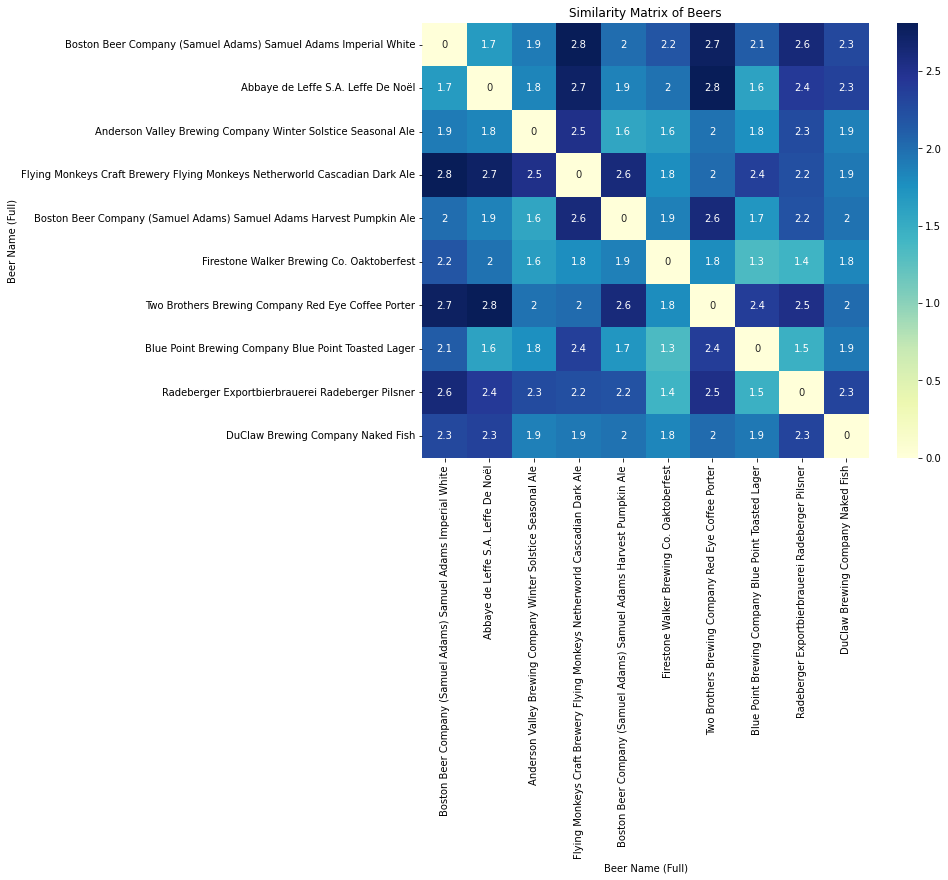

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(euclidean_distance_matrix, annot=True, cmap='YlGnBu', vmin=0, vmax=np.max(euclidean_distance_matrix)[1])
plt.title('Similarity Matrix of Beers')
plt.show()


Write a function that gives you the items most similar to a chosen one

In [10]:
def plot_distance_scores(distance_df, beer_name):
    # Get distance scores for the given beer
    distance_scores = distance_df.loc[beer_name].sort_values()
    top_closest_beers = distance_scores.iloc[1:6]
    # Plotting the distances
    plt.figure(figsize=(10, 6))
    top_closest_beers.plot(kind='barh', color='lightgreen')
    plt.xlabel('Euclidean Distance')
    plt.title(f'Top 5 Beers Closest to "{beer_name}" (by Euclidean Distance)')
    plt.gca().invert_yaxis()  # Invert y-axis to show smallest distance at the top
    plt.show()
    #print description
    print(f"Descriptions of the top 5 beers closest to '{beer_name}':")
    for beer in top_closest_beers.index:
        description = df[df['Beer Name (Full)'] == beer]['Description'].values[0]
        quantities = df[df['Beer Name (Full)'] == beer][['Body', 'Alcohol', 'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty','Style']].values[0]
        print(f"{beer}:")
        print(f"  Style: {quantities[-1]}")
        print(f"Description: {description}")
        print("Quantities:")
        print(f"  Body: {quantities[0]}")
        print(f"  Alcohol: {quantities[1]}")
        print(f"  Bitter: {quantities[2]}")
        print(f"  Sweet: {quantities[3]}")
        print(f"  Sour: {quantities[4]}")
        print(f"  Salty: {quantities[5]}")
        print(f"  Fruits: {quantities[6]}")
        print(f"  Hoppy: {quantities[7]}")
        print(f"  Spices: {quantities[8]}")
        print(f"  Malty: {quantities[9]}\n")
        print(f"{beer}: {description}\n")

Let's select a beer and analyze the most similar items. Let's use the definition to check if the prediction make sense

Chosen beer:
Boston Beer Company (Samuel Adams) Samuel Adams Imperial White
Wheat Beer - Witbier
Notes:
  Body: 0.44000000000000006
  Alcohol: 1.0
  Bitter: 0.034482758620689655
  Sweet: 0.4166666666666667
  Sour: 0.9999999999999999
  Salty: 0.0
  Fruits: 0.7250000000000001
  Hoppy: 0.2616822429906542
  Spices: 0.6122448979591837
  Malty: 0.22123893805309736



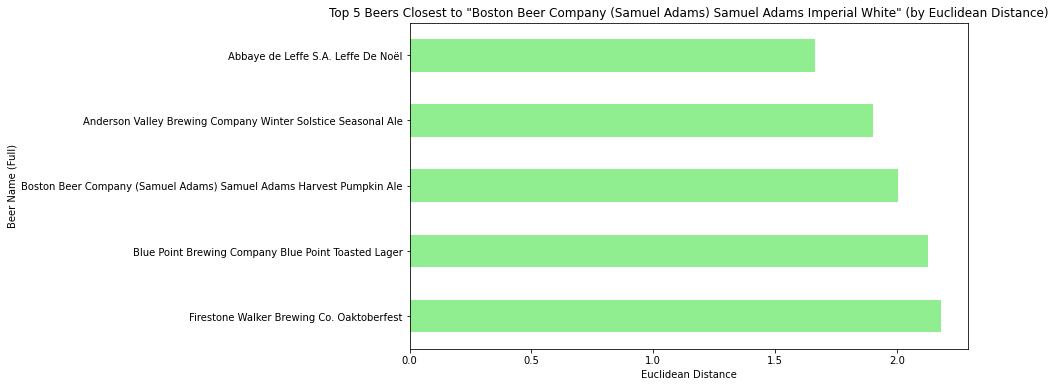

Descriptions of the top 5 beers closest to 'Boston Beer Company (Samuel Adams) Samuel Adams Imperial White':
Abbaye de Leffe S.A. Leffe De Noël:
  Style: Brown Ale - Belgian Dark
Description: Notes:
Quantities:
  Body: 0.20000000000000004
  Alcohol: 0.47619047619047616
  Bitter: 0.08620689655172414
  Sweet: 0.44696969696969696
  Sour: 0.49999999999999994
  Salty: 0.0
  Fruits: 0.28750000000000003
  Hoppy: 0.05607476635514018
  Spices: 0.836734693877551
  Malty: 0.22123893805309736

Abbaye de Leffe S.A. Leffe De Noël: Notes:

Anderson Valley Brewing Company Winter Solstice Seasonal Ale:
  Style: Winter Warmer
Description: Notes:Winter Solstice® is our take on the classic style of “winter warmer.” Boasting a deep amber hue and rich mouthfeel, its creamy finish will lift your spirits. Hints of toffee, spice, and caramel tease the senses making this the perfect ale to share with friends and family during the cold days and long nights of winter.\t
Quantities:
  Body: 0.2266666666666667
  Al

In [11]:
given_beer = df['Beer Name (Full)'][0]
quantities = df[df['Beer Name (Full)'] == given_beer][['Body', 'Alcohol', 'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty']].values[0]
 
print('Chosen beer:')
print(df['Beer Name (Full)'][0])
print(df['Style'][0])
print(df['Description'][0])
print(f"  Body: {quantities[0]}")
print(f"  Alcohol: {quantities[1]}")
print(f"  Bitter: {quantities[2]}")
print(f"  Sweet: {quantities[3]}")
print(f"  Sour: {quantities[4]}")
print(f"  Salty: {quantities[5]}")
print(f"  Fruits: {quantities[6]}")
print(f"  Hoppy: {quantities[7]}")
print(f"  Spices: {quantities[8]}")
print(f"  Malty: {quantities[9]}\n")

plot_distance_scores(euclidean_distance_matrix, given_beer)